In [15]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [16]:
import tensorflow as tf
import datetime
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical


In [17]:
#load cifar10 dataset and split it
cifar = tfds.load("cifar10", split=["train","test"], as_supervised=True)

train_ds = cifar[0]
val_ds = cifar[1]

In [18]:
batchsize = 32

In [19]:
for img1, label in train_ds.take(1):
  print(img1.shape, label.shape)

(32, 32, 3) ()


In [20]:
def prepare_cifar10_data(cifar10, batchsize=4):
    # Convert data from uint8 to float32
    cifar10 = cifar10.map(lambda img, target: (tf.cast(img, tf.float32), target))
    # Sloppy input normalization, bringing image values from range [0, 255] to [-1, 1]
    cifar10 = cifar10.map(lambda img, target: ((img / 128.) - 1., target))
    # Create one-hot targets
    cifar10 = cifar10.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
    # Cache this progress in memory, as there is no need to redo it; it is deterministic after all
    cifar10 = cifar10.cache()
    # Shuffle, batch, prefetch
    cifar10 = cifar10.shuffle(1000)
    cifar10 = cifar10.batch(batchsize)
    cifar10 = cifar10.prefetch(20)
    # Return preprocessed dataset
    return cifar10

In [21]:
train_dataset = prepare_cifar10_data(train_ds,batchsize)
val_dataset = prepare_cifar10_data(val_ds,batchsize)

In [22]:
for img1, label in train_ds.take(1):
  print(img1.shape, label.shape)

(32, 32, 3) ()


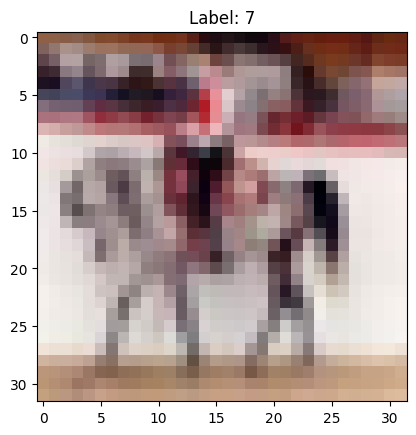

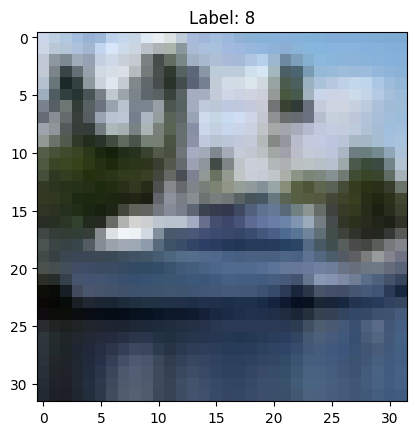

In [23]:
for img1, label in train_ds.take(2):
    # Convert image tensor to numpy array
    image_np = img1.numpy()

    # Display the image
    plt.imshow(image_np)
    plt.title(f"Label: {label.numpy()}")
    plt.show()

In [24]:
class MLPModel(tf.keras.Model):

  #1 Constructor
  def __init__(self):
    super(MLPModel, self).__init__()
    #inherit functionality from parent class

    #optimizer, loss function and metrics
    self.metrics_list = [
                        tf.keras.metrics.Mean(name="loss"),
                        tf.keras.metrics.CategoricalAccuracy(name="acc"),
                        tf.keras.metrics.TopKCategoricalAccuracy(3,name="top-3-acc")
                       ]
    self.optimizer = tf.keras.optimizers.Adam()
    self.loss = tf.keras.losses.CategoricalCrossentropy()

    # layers to be used
    self.convlayer1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')
    self.convlayer2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')
    self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

    self.convlayer3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')
    self.convlayer4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')
    self.global_pool = tf.keras.layers.GlobalAvgPool2D()

    self.out = tf.keras.layers.Dense(10, activation='softmax')


  #2. call method (forward computation)
  def call(self, img, training=False):
    x = self.convlayer1(img)
    x = self.convlayer2(x)
    x = self.pooling(x)
    x = self.convlayer3(x)
    x = self.convlayer4(x)
    x = self.global_pool(x)

    return self.out(x)

In [25]:
"""class MLPModel(tf.keras.Model):
  def __init__(self):
    super(MLPModel, self).__init__()

    self.conv_layer1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")
    self.conv_layer2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")
    self.maxpool_layer = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

    self.conv_layer3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")
    self.conv_layer4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")
    self.globalpooling_layer = tf.keras.layers.GlobalAveragePooling2D()

    self.flatten = tf.keras.layers.Flatten()
    self.dense = tf.keras.layers.Dense(64, activation='relu')
    self.out = tf.keras.layers.Dense(10, activation="softmax")

  def call(self, x):
    x = self.conv_layer1(x)
    x = self.conv_layer2(x)
    x = self.maxpool_layer(x)
    x = self.conv_layer3(x)
    x = self.conv_layer4(x)
    x = self.globalpooling_layer(x)
    x = self.flatten(x)
    x = self.dense(x)
    y = self.out(x)
    return y"""

'class MLPModel(tf.keras.Model):\n  def __init__(self):\n    super(MLPModel, self).__init__()\n\n    self.conv_layer1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")\n    self.conv_layer2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")\n    self.maxpool_layer = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)\n\n    self.conv_layer3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")\n    self.conv_layer4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")\n    self.globalpooling_layer = tf.keras.layers.GlobalAveragePooling2D()\n\n    self.flatten = tf.keras.layers.Flatten()\n    self.dense = tf.keras.layers.Dense(64, activation=\'relu\')\n    self.out = tf.keras.layers.Dense(10, activation="softmax")\n\n  def call(self, x):\n    x = self.conv_layer1(x)\n    x = self.conv_layer2(x)\n    x = self.maxpool_layer(x)\n    x = self.conv_layer

In [26]:
"""def train_test_cifar_model(train_ds, test_ds, model, loss_func, optimizer, num_epochs):
  # Initialize lists to store training and test loss and accuracy
  train_loss_list = []
  train_accuracy_list = []
  test_loss_list = []
  test_accuracy_list = []

  # Initialize the accuracy metrics
  train_accuracy_metric = tf.keras.metrics.Accuracy()
  test_accuracy_metric = tf.keras.metrics.Accuracy()

  for epoch in range(num_epochs):
    # Training
    total_train_loss = 0.0
    train_accuracy_metric.reset_states()

    for inputs, labels in train_ds:
        with tf.GradientTape() as tape:
            outputs = model(inputs)
            train_loss = loss_func(labels, outputs)

        gradients = tape.gradient(train_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        total_train_loss += train_loss.numpy()
        train_accuracy_metric.update_state(tf.argmax(labels, axis=1), tf.argmax(outputs, axis=1))

    average_train_loss = total_train_loss / len(train_ds)
    train_accuracy = train_accuracy_metric.result().numpy()

    # Testing
    total_test_loss = 0.0
    test_accuracy_metric.reset_states()

    for test_inputs, test_labels in test_ds:
        test_outputs = model(test_inputs)
        test_loss = loss_func(test_labels, test_outputs)

        total_test_loss += test_loss.numpy()
        test_accuracy_metric.update_state(tf.argmax(test_labels, axis=1), tf.argmax(test_outputs, axis=1))

    average_test_loss = total_test_loss / len(test_ds)
    test_accuracy = test_accuracy_metric.result().numpy()

    # Print or log the values
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    # Store values for plotting
    train_loss_list.append(average_train_loss)
    train_accuracy_list.append(train_accuracy)
    test_loss_list.append(average_test_loss)
    test_accuracy_list.append(test_accuracy)

  return (train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list)"""

"def train_test_cifar_model(train_ds, test_ds, model, loss_func, optimizer, num_epochs):\n  # Initialize lists to store training and test loss and accuracy\n  train_loss_list = []\n  train_accuracy_list = []\n  test_loss_list = []\n  test_accuracy_list = []\n\n  # Initialize the accuracy metrics\n  train_accuracy_metric = tf.keras.metrics.Accuracy()\n  test_accuracy_metric = tf.keras.metrics.Accuracy()\n\n  for epoch in range(num_epochs):\n    # Training\n    total_train_loss = 0.0\n    train_accuracy_metric.reset_states()\n\n    for inputs, labels in train_ds:\n        with tf.GradientTape() as tape:\n            outputs = model(inputs)\n            train_loss = loss_func(labels, outputs)\n\n        gradients = tape.gradient(train_loss, model.trainable_variables)\n        optimizer.apply_gradients(zip(gradients, model.trainable_variables))\n\n        total_train_loss += train_loss.numpy()\n        train_accuracy_metric.update_state(tf.argmax(labels, axis=1), tf.argmax(outputs, axis=1)

In [27]:
def train_cifar_10(model, train_ds, test_ds, num_epochs, lr):
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
    test_loss = tf.keras.metrics.Mean(name='test_loss')
    test_accuracy = tf.keras.metrics.CategoricalAccuracy(name="test_accuracy")

    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    @tf.function
    def train_step(images, labels):
        with tf.GradientTape() as tape:
            predictions = model(images)
            loss = loss_object(labels, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss(loss)
        train_accuracy(labels, predictions)

    @tf.function
    def test_step(images, labels):
        predictions = model(images)
        t_loss = loss_object(labels, predictions)

        test_loss(t_loss)
        test_accuracy(labels, predictions)

    for epoch in range(num_epochs):
        # Training loop
        for images, labels in train_ds:
            train_step(images, labels)

        # Testing loop
        for test_images, test_labels in test_ds:
            test_step(test_images, test_labels)

        # Save metrics for plotting
        train_losses.append(train_loss.result().numpy())
        train_accuracies.append(train_accuracy.result().numpy())
        test_losses.append(test_loss.result().numpy())
        test_accuracies.append(test_accuracy.result().numpy())

        template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.2f}%, Test Loss: {:.4f}, Test Accuracy: {:.2f}%'
        print(template.format(epoch + 1,
                              train_loss.result(),
                              train_accuracy.result() * 100,
                              test_loss.result(),
                              test_accuracy.result() * 100))

        # Reset the metrics for the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

    # Plotting
    plt.figure(figsize=(12, 4))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.title('Training and Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train')
    plt.plot(test_accuracies, label='Test')
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1, Loss: 1.7581, Accuracy: 33.56%, Test Loss: 1.6016, Test Accuracy: 41.97%
Epoch 2, Loss: 1.4466, Accuracy: 47.34%, Test Loss: 1.3075, Test Accuracy: 52.97%
Epoch 3, Loss: 1.3013, Accuracy: 53.36%, Test Loss: 1.2063, Test Accuracy: 56.81%
Epoch 4, Loss: 1.2263, Accuracy: 56.31%, Test Loss: 1.2400, Test Accuracy: 56.10%
Epoch 5, Loss: 1.1771, Accuracy: 57.98%, Test Loss: 1.1640, Test Accuracy: 58.62%
Epoch 6, Loss: 1.1404, Accuracy: 59.47%, Test Loss: 1.1569, Test Accuracy: 58.59%
Epoch 7, Loss: 1.1166, Accuracy: 60.08%, Test Loss: 1.1943, Test Accuracy: 57.62%
Epoch 8, Loss: 1.0980, Accuracy: 61.13%, Test Loss: 1.1472, Test Accuracy: 59.21%
Epoch 9, Loss: 1.0769, Accuracy: 62.03%, Test Loss: 1.1225, Test Accuracy: 60.50%
Epoch 10, Loss: 1.0598, Accuracy: 62.58%, Test Loss: 1.1429, Test Accuracy: 59.77%
Epoch 11, Loss: 1.0434, Accuracy: 63.00%, Test Loss: 1.2143, Test Accuracy: 57.94%
Epoch 12, Loss: 1.0363, Accuracy: 63.37%, Test Loss: 1.1570, Test Accuracy: 59.34%
Epoch 13, Los

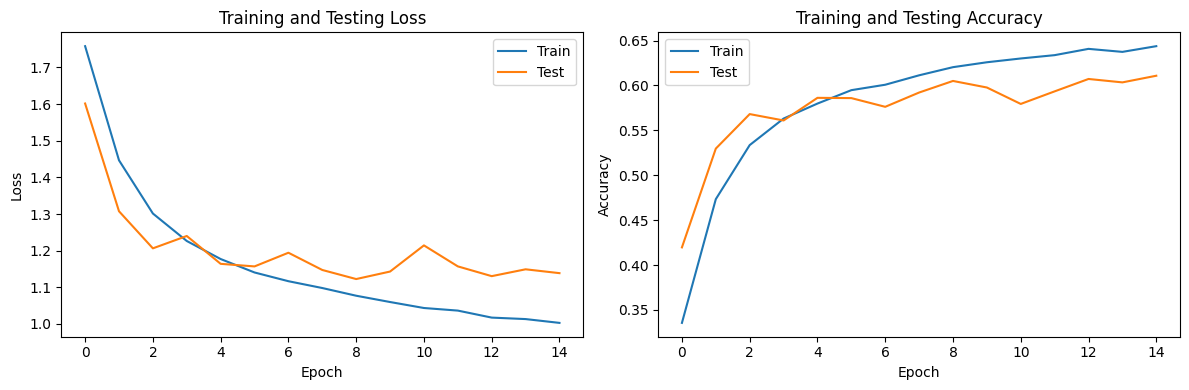

In [28]:
basic_model = MLPModel()
basic_model(tf.keras.Input((32,32,3)))
learning_rate = 0.01
cce = tf.keras.losses.CategoricalCrossentropy()
optimizer_Adam = tf.keras.optimizers.Adam(learning_rate=0.01)
num_epochs = 15

basic_model.compile(optimizer_Adam, cce, metrics=["accuracy", "loss"])
#basic_model.summary()
train_cifar_10(basic_model, train_dataset, val_dataset, num_epochs, learning_rate)

In [29]:
#(train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list) = traintrain_test_cifar_model_test_cafar_model(train_dataset, val_dataset, basic_model, cce, optimizer_Adam, num_epochs)




In [30]:
"""basic_model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
#path for saving the logs
path = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=path,histogram_freq=1)"""

'basic_model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])\n#path for saving the logs\npath = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")\ntensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=path,histogram_freq=1)'

In [31]:
"""img, label = train_dataset
basic_model.fit(img, label, epochs = 5, callbacks = [tensorboard_callback])"""

'img, label = train_dataset\nbasic_model.fit(img, label, epochs = 5, callbacks = [tensorboard_callback])'

In [32]:
"""basic_model.summary()"""

'basic_model.summary()'